In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import tqdm
from tqdm import tqdm_notebook
from string import punctuation

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Model LightGBM Regressor
import lightgbm as lgb

# Model NN Keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras import regularizers
import tensorflow as tf


# Options
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)
import re
import gc
gc.enable()

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

/Users/rodrigolima82/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
#train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
train = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'}, low_memory=False)
#train = train[:2200]
print(train.shape)
train.head()

(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


## Feature engineering

In [3]:
#https://www.kaggle.com/rooshroosh/fork-of-neural-networks-different-architecture
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic


def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"
    
# Funcao para agrupar as descricoes dos tipos de estadio
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    return np.nan

# Funcao para agrupar as descricoes dos estadios
def agrupar_estadio(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

    
# Funcao para agrupar a localizacao do estadio e do jogo
def clean_Location(Location):

    if Location == "Arlington, Texas":
        return "Arlington, TX"
    elif Location in ("Baltimore, Maryland","Baltimore, Md."):
        return "Baltimore, MD"
    elif Location == "Charlotte, North Carolina":
        return "Charlotte, NC"
    elif Location == "Chicago. IL":
        return "Chicago, IL"
    elif Location == "Cincinnati, Ohio":
        return "Cincinnati, OH"
    elif Location in ("Cleveland","Cleveland Ohio","Cleveland, Ohio","Cleveland,Ohio"):
        return "Cleveland, OH"
    elif Location == "Detroit":
        return "Detroit, MI"
    elif Location == "E. Rutherford, NJ" or Location == "East Rutherford, N.J.":
        return "East Rutherford, NJ"
    elif Location == "Foxborough, Ma":
        return "Foxborough, MA"
    elif Location == "Houston, Texas":
        return "Houston, TX"
    elif Location in ("Jacksonville Florida","Jacksonville, Fl","Jacksonville, Florida"):
        return "Jacksonville, FL"
    elif Location == "London":
        return "London, England"
    elif Location == "Los Angeles, Calif.":
        return "Los Angeles, CA"
    elif Location == "Miami Gardens, Fla.":
        return "Miami Gardens, FLA"
    elif Location in ("New Orleans","New Orleans, La."):
        return "New Orleans, LA"
    elif Location == "Orchard Park NY":
        return "Orchard Park, NY"
    elif Location == "Philadelphia, Pa.":
        return "Philadelphia, PA"
    elif Location == "Pittsburgh":
        return "Pittsburgh, PA"
    elif Location == "Seattle":
        return "Seattle, WA"
    else:
        return Location
    

# Funcao para agrupar os dados de direcao do vento
def clean_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = txt.replace('from', '')
    txt = txt.replace(' ', '')
    txt = txt.replace('north', 'n')
    txt = txt.replace('south', 's')
    txt = txt.replace('west', 'w')
    txt = txt.replace('east', 'e')
    return txt

def transform_WindDirection(txt):
    if pd.isna(txt):
        return np.nan
    
    if txt=='n':
        return 0
    if txt=='nne' or txt=='nen':
        return 1/8
    if txt=='ne':
        return 2/8
    if txt=='ene' or txt=='nee':
        return 3/8
    if txt=='e':
        return 4/8
    if txt=='ese' or txt=='see':
        return 5/8
    if txt=='se':
        return 6/8
    if txt=='ses' or txt=='sse':
        return 7/8
    if txt=='s':
        return 8/8
    if txt=='ssw' or txt=='sws':
        return 9/8
    if txt=='sw':
        return 10/8
    if txt=='sww' or txt=='wsw':
        return 11/8
    if txt=='w':
        return 12/8
    if txt=='wnw' or txt=='nww':
        return 13/8
    if txt=='nw':
        return 14/8
    if txt=='nwn' or txt=='nnw':
        return 15/8
    return np.nan

    
# Funcao para converter a velocidade do vento
def convert_wind_speed(WindSpeed):
    ws = str(WindSpeed)

    if ws.isdigit():
        return int(ws)

    if '-' in ws:
        return int(ws.split('-')[0])

    if ws.split(' ')[0].isdigit():
        return int(ws.split(' ')[0])

    if 'mph' in ws.lower():
        return int(ws.lower().split('mph')[0])
    else:
        return 0

def transform_time_quarter(str1):
    return int(str1[:2])*60 + int(str1[3:5])

def transform_time_all(str1,quarter):
    if quarter<=4:
        return 15*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60
    if quarter ==5:
        return 10*60 - (int(str1[:2])*60 + int(str1[3:5])) + (quarter-1)*15*60

In [4]:
def create_features(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        static_features = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                            'YardLine','Quarter','Down','Distance','DefendersInTheBox']].drop_duplicates()
        static_features['DefendersInTheBox'] = static_features['DefendersInTheBox'].fillna(np.mean(static_features['DefendersInTheBox']))

        return static_features


    def combine_features(relative_to_back, defense, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats, deploy=deploy)
    
    return basetable

In [5]:
%%time
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()
train_basetable1 = create_features(train, False)

CPU times: user 1min 17s, sys: 1.32 s, total: 1min 18s
Wall time: 1min 13s


In [6]:
def preprocess(train):

    # Features Rodrigo
    #INICIO ======================================================================
    
    #train['StadiumType'] = train['StadiumType'].apply(clean_StadiumType)
    #train['StadiumType'] = train['StadiumType'].apply(transform_StadiumType)

    #train['Location'] = train['Location'].apply(clean_Location)

    train[(train['PossessionTeam']!=train['HomeTeamAbbr']) & (train['PossessionTeam']!=train['VisitorTeamAbbr'])][['PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr']]
    train['DefendersInTheBox_vs_Distance'] = train['DefendersInTheBox'] / train['Distance']

    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in train['PossessionTeam'].unique():
        map_abbr[abb] = abb

    train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
    train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)
    train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].map(map_abbr)
    train['HomePossesion'] = train['PossessionTeam'] == train['HomeTeamAbbr']    
    
    #train['Field_eq_Possession'] = train['FieldPosition'] == train['PossessionTeam']
    #train['HomeField'] = train['FieldPosition'] == train['HomeTeamAbbr']
    train['time_quarter'] = train.GameClock.map(lambda x:transform_time_quarter(x))
    train['time_end'] = train.apply(lambda x:transform_time_all(x.loc['GameClock'],x.loc['Quarter']),axis=1)
    train['WindDirection'] = train['WindDirection'].apply(clean_WindDirection)
    train['WindDirection'] = train['WindDirection'].apply(transform_WindDirection)
    #train['PlayDirection'] = train['PlayDirection'].apply(lambda x: x.strip() == 'right')   
    #train['Team'] = train['Team'].apply(lambda x: x.strip()=='home')
    #train['YardsLeft'] = train.apply(lambda row: 100-row['YardLine'] if row['HomeField'] else row['YardLine'], axis=1)
    #train['YardsLeft'] = train.apply(lambda row: row['YardsLeft'] if row['PlayDirection'] else 100-row['YardsLeft'], axis=1)

    #FIM ======================================================================

    ## GameClock
    train['GameClock_sec'] = train['GameClock'].apply(strtoseconds)
    train["GameClock_minute"] = train["GameClock"].apply(lambda x : x.split(":")[0]).astype("object")

    ## Height
    train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: (12*int(x.split('-')[0])+int(x.split('-')[1]) * 2.54/100))

    train['PlayerBMI'] = 703*(train['PlayerWeight']/(train['PlayerHeight'])**2)

    ## Time
    train['TimeHandoff'] = train['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
    train['TimeSnap'] = train['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

    train['TimeDelta'] = train.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
    train['PlayerBirthDate'] = train['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

    ## Age
    seconds_in_year = 60*60*24*365.25
    train['PlayerAge'] = train.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
    train["PlayerAge_ob"] = train['PlayerAge'].astype(np.int).astype("object")

    ## WindSpeed
    train['WindSpeed_ob'] = train['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    train['WindSpeed_ob'] = train['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    train['WindSpeed_dense'] = train['WindSpeed_ob'].apply(strtofloat)

    ## Weather
    train['GameWeather_process'] = train['GameWeather'].str.lower()
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    train['GameWeather_process'] = train['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    train['GameWeather_dense'] = train['GameWeather_process'].apply(map_weather)

    ## Rusher
    train['IsRusher'] = (train['NflId'] == train['NflIdRusher'])
    train['IsRusher_ob'] = (train['NflId'] == train['NflIdRusher']).astype("object")
    temp = train[train["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
    train = train.merge(temp, on = "PlayId")
    train["IsRusherTeam"] = train["Team"] == train["RusherTeam"]

    ## dense -> categorical
    train["Quarter_ob"] = train["Quarter"].astype("object")
    train["Down_ob"] = train["Down"].astype("object")
    train["JerseyNumber_ob"] = train["JerseyNumber"].astype("object")
    train["YardLine_ob"] = train["YardLine"].astype("object")
    train["DefendersInTheBox_ob"] = train["DefendersInTheBox"].astype("object")
    train["Week_ob"] = train["Week"].astype("object")
    train["TimeDelta_ob"] = train["TimeDelta"].astype("object")


    ## Orientation and Dir
    train["Orientation_ob"] = train["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
    train["Dir_ob"] = train["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

    train["Orientation_sin"] = train["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Orientation_cos"] = train["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
    train["Dir_sin"] = train["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
    train["Dir_cos"] = train["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))

    
    # Runner horizontal speed
    radian_angle = (90 - train['Dir']) * np.pi / 180.0
    train['v_horizontal'] = np.abs(train['S'] * np.cos(radian_angle))
    train['v_vertical'] = np.abs(train['S'] * np.sin(radian_angle))


    ## diff Score
    train["diffScoreBeforePlay"] = train["HomeScoreBeforePlay"] - train["VisitorScoreBeforePlay"]
    train["diffScoreBeforePlay_binary_ob"] = (train["HomeScoreBeforePlay"] > train["VisitorScoreBeforePlay"]).astype("object")

    ## Turf
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 
    train['Turf'] = train['Turf'].map(Turf)

    ## OffensePersonnel
    temp = train["OffensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(OffensePersonnelSplit(x)))
    temp.columns = ["Offense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")

    ## DefensePersonnel
    temp = train["DefensePersonnel"].iloc[np.arange(0, len(train), 22)].apply(lambda x : pd.Series(DefensePersonnelSplit(x)))
    temp.columns = ["Defense" + c for c in temp.columns]
    temp["PlayId"] = train["PlayId"].iloc[np.arange(0, len(train), 22)]
    train = train.merge(temp, on = "PlayId")
    
    ## sort
    #train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'Team', 'IsRusher']).reset_index(drop = True)
    train = train.sort_values(by = ['X']).sort_values(by = ['Dis']).sort_values(by=['PlayId', 'IsRusherTeam', 'IsRusher']).reset_index(drop = True)
    
    return train

In [7]:
%%time
train_basetable2 = preprocess(train)

CPU times: user 2min 31s, sys: 7.13 s, total: 2min 38s
Wall time: 2min 18s


In [8]:
## DisplayName remove Outlier
v = train_basetable2["DisplayName"].value_counts()
missing_values = list(v[v < 5].index)
train_basetable2["DisplayName"] = train_basetable2["DisplayName"].where(~train_basetable2["DisplayName"].isin(missing_values), "nan")

## PlayerCollegeName remove Outlier
v = train_basetable2["PlayerCollegeName"].value_counts()
missing_values = list(v[v < 10].index)
train_basetable2["PlayerCollegeName"] = train_basetable2["PlayerCollegeName"].where(~train_basetable2["PlayerCollegeName"].isin(missing_values), "nan")


In [9]:
def drop(tt, deploy=False):
    drop_cols = ['GameId', 'GameWeather', 'NflId', 'Season', 'NflIdRusher'] 
    drop_cols += ['TimeHandoff', 'TimeSnap', 'PlayerBirthDate']
    drop_cols += ['Orientation', "Dir", 'WindSpeed', 'GameClock']
    drop_cols += ["DefensePersonnel","OffensePersonnel"]
    drop_cols += ["X","Y","S","A","Dis","YardLine","Quarter","Down","Distance","DefendersInTheBox"]
    if not deploy:
        drop_cols += ["Yards"]
    tt = tt.drop(drop_cols, axis = 1)
    return tt

In [10]:
train_basetable2 = drop(train_basetable2)

In [11]:
train_basetable1.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,Yards
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8
1,2017090700,20170907000139,4.07,0,0,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,48.93,27.16,3.06,2.41,0.34,149.30,47.80,53.0,1,1,10,6.0,3
2,2017090700,20170907000189,3.66,1,0,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,71.34,19.11,5.77,2.42,0.60,219.18,138.04,75.0,1,1,10,7.0,5
3,2017090700,20170907000345,3.53,0,0,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,104.47,25.36,4.45,3.20,0.46,173.78,84.56,108.0,1,2,2,9.0,2
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,7


In [12]:
train_basetable2.head()

,PlayId,Team,DisplayName,JerseyNumber,PossessionTeam,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,PlayDirection,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,Temperature,Humidity,WindDirection,DefendersInTheBox_vs_Distance,HomePossesion,time_quarter,time_end,GameClock_sec,GameClock_minute,PlayerBMI,TimeDelta,PlayerAge,PlayerAge_ob,WindSpeed_ob,WindSpeed_dense,GameWeather_process,GameWeather_dense,IsRusher,IsRusher_ob,RusherTeam,IsRusherTeam,Quarter_ob,Down_ob,JerseyNumber_ob,YardLine_ob,DefendersInTheBox_ob,Week_ob,TimeDelta_ob,Orientation_ob,Dir_ob,Orientation_sin,Orientation_cos,Dir_sin,Dir_cos,v_horizontal,v_vertical,diffScoreBeforePlay,diffScoreBeforePlay_binary_ob,OffenseDB,OffenseDL,OffenseLB,OffenseOL,OffenseQB,OffenseRB,OffenseTE,OffenseWR,DefenseDB,DefenseDL,DefenseLB,DefenseOL
0,20170907000118,away,Chris Jones,95,NE,NE,0,0,SHOTGUN,left,72.1524,308,Mississippi State,DT,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,41.591490,1.0,23.184204,23,8,8.0,clear and warm,1.0,False,False,home,False,1,3,95,35,6,1,1,1,5,0.299374,0.954136,0.997391,0.072194,0.718121,0.051980,0,False,0,0,0,0,0,1,1,3,6,2,3,0
1,20170907000118,away,Allen Bailey,97,NE,NE,0,0,SHOTGUN,left,72.0762,288,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,38.973019,1.0,28.457305,28,8,8.0,clear and warm,1.0,False,False,home,False,1,3,97,35,6,1,1,22,10,-0.463451,0.886123,0.320613,-0.947210,0.134657,0.397828,0,False,0,0,0,0,0,1,1,3,6,2,3,0
2,20170907000118,away,Derrick Johnson,56,NE,NE,0,0,SHOTGUN,left,72.0762,245,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,33.154131,1.0,34.795430,34,8,8.0,clear and warm,1.0,False,False,home,False,1,3,56,35,6,1,1,0,16,0.004014,0.999992,-0.962975,-0.269592,0.404449,0.113229,0,False,0,0,0,0,0,1,1,3,6,2,3,0
3,20170907000118,away,Terrance Mitchell,39,NE,NE,0,0,SHOTGUN,left,60.2794,190,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,36.759626,1.0,25.311514,25,8,8.0,clear and warm,1.0,False,False,home,False,1,3,39,35,6,1,1,0,2,0.048327,0.998832,0.607514,0.794309,0.674341,0.881683,0,False,0,0,0,0,0,1,1,3,6,2,3,0
4,20170907000118,away,Phillip Gaines,23,NE,NE,0,0,SHOTGUN,left,72.0000,193,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,26.172647,1.0,26.431295,26,8,8.0,clear and warm,1.0,False,False,home,False,1,3,23,35,6,1,1,2,5,0.522201,0.852822,1.000000,0.000698,1.240000,0.000866,0,False,0,0,0,0,0,1,1,3,6,2,3,0


### Concatenar Features baseline1 + baseline2

In [13]:
train = pd.merge(train_basetable1, train_basetable2, on='PlayId', how='inner')

In [14]:
train.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,Yards,Team,DisplayName,JerseyNumber,PossessionTeam,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,OffenseFormation,PlayDirection,PlayerHeight,PlayerWeight,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,Temperature,Humidity,WindDirection,DefendersInTheBox_vs_Distance,HomePossesion,time_quarter,time_end,GameClock_sec,GameClock_minute,PlayerBMI,TimeDelta,PlayerAge,PlayerAge_ob,WindSpeed_ob,WindSpeed_dense,GameWeather_process,GameWeather_dense,IsRusher,IsRusher_ob,RusherTeam,IsRusherTeam,Quarter_ob,Down_ob,JerseyNumber_ob,YardLine_ob,DefendersInTheBox_ob,Week_ob,TimeDelta_ob,Orientation_ob,Dir_ob,Orientation_sin,Orientation_cos,Dir_sin,Dir_cos,v_horizontal,v_vertical,diffScoreBeforePlay,diffScoreBeforePlay_binary_ob,OffenseDB,OffenseDL,OffenseLB,OffenseOL,OffenseQB,OffenseRB,OffenseTE,OffenseWR,DefenseDB,DefenseDL,DefenseLB,DefenseOL
0,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.59331,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8,away,Chris Jones,95,NE,NE,0,0,SHOTGUN,left,72.1524,308,Mississippi State,DT,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,41.591490,1.0,23.184204,23,8,8.0,clear and warm,1.0,False,False,home,False,1,3,95,35,6,1,1,1,5,0.299374,0.954136,0.997391,0.072194,0.718121,0.051980,0,False,0,0,0,0,0,1,1,3,6,2,3,0
1,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.59331,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8,away,Allen Bailey,97,NE,NE,0,0,SHOTGUN,left,72.0762,288,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,38.973019,1.0,28.457305,28,8,8.0,clear and warm,1.0,False,False,home,False,1,3,97,35,6,1,1,22,10,-0.463451,0.886123,0.320613,-0.947210,0.134657,0.397828,0,False,0,0,0,0,0,1,1,3,6,2,3,0
2,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.59331,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8,away,Derrick Johnson,56,NE,NE,0,0,SHOTGUN,left,72.0762,245,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,33.154131,1.0,34.795430,34,8,8.0,clear and warm,1.0,False,False,home,False,1,3,56,35,6,1,1,0,16,0.004014,0.999992,-0.962975,-0.269592,0.404449,0.113229,0,False,0,0,0,0,0,1,1,3,6,2,3,0
3,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.59331,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8,away,Terrance Mitchell,39,NE,NE,0,0,SHOTGUN,left,60.2794,190,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,36.759626,1.0,25.311514,25,8,8.0,clear and warm,1.0,False,False,home,False,1,3,39,35,6,1,1,0,2,0.048327,0.998832,0.607514,0.794309,0.674341,0.881683,0,False,0,0,0,0,0,1,1,3,6,2,3,0
4,2017090700,20170907000118,3.75,1,0,1.449724,22.415872,8.046559,4.873845,4.59331,22.415872,9.752491,5.327299,41.25,30.53,3.63,3.35,0.38,198.02,114.26,45.0,1,3,2,6.0,8,away,Phillip Gaines,23,NE,NE,0,0,SHOTGUN,left,72.0000,193,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Artificial,63.0,77.0,1.25,3.0,True,854,46,854.0,14,26.172647,1.0,26.431295,26,8,8.0,clear and warm,1.0,False,False,home,False,1,3,23,35,6,1,1,2,5,0.522201,0.852822,1.000000,0.000698,1.240000,0.000866,0,False,0,0,0,0,0,1,1,3,6,2,3,0


### Separando features categoricas e numericas

In [15]:
cat_features = []
dense_features = []
for col in train.columns:
    if train[col].dtype =='object':
        cat_features.append(col)
        #print("*cat*", col, len(train[col].unique()))
    else:
        dense_features.append(col)
        #print("!dense!", col, len(train[col].unique()))
dense_features.remove("PlayId")
dense_features.remove("Yards")

## categorical

In [16]:
train_cat = train[cat_features]
categories = []
most_appear_each_categories = {}
for col in tqdm_notebook(train_cat.columns):
    train_cat.loc[:,col] = train_cat[col].fillna("nan")
    train_cat.loc[:,col] = col + "__" + train_cat[col].astype(str)
    most_appear_each_categories[col] = list(train_cat[col].value_counts().index)[0]
    categories.append(train_cat[col].unique())
categories = np.hstack(categories)
print(len(categories))


3097


In [17]:
le = LabelEncoder()
le.fit(categories)
for col in tqdm_notebook(train_cat.columns):
    train_cat.loc[:, col] = le.transform(train_cat[col])
num_classes = len(le.classes_)

## Numeric

In [18]:
train_dense = train[dense_features]
sss = {}
medians = {}
for col in tqdm_notebook(train_dense.columns):
    #print(col)
    medians[col] = np.nanmedian(train_dense[col])
    train_dense.loc[:, col] = train_dense[col].fillna(medians[col])
    ss = StandardScaler()
    train_dense.loc[:, col] = ss.fit_transform(train_dense[col].values[:,None])
    sss[col] = ss

## Divide features into groups

In [19]:
## dense features for play
dense_game_features = train_dense.columns[train_dense[:22].std() == 0]
## dense features for each player
dense_player_features = train_dense.columns[train_dense[:22].std() != 0]
## categorical features for play
cat_game_features = train_cat.columns[train_cat[:22].std() == 0]
## categorical features for each player
cat_player_features = train_cat.columns[train_cat[:22].std() != 0]

In [20]:
train_dense_game = train_dense[dense_game_features].iloc[np.arange(0, len(train), 22)].reset_index(drop = True).values
train_dense_game = np.hstack([train_dense_game, train_dense[dense_player_features][train_dense["IsRusher"] > 0]]) ## with rusher player feature

train_dense_players = [train_dense[dense_player_features].iloc[np.arange(k, len(train), 22)].reset_index(drop = True) for k in range(22)]
train_dense_players = np.stack([t.values for t in train_dense_players]).transpose(1, 0, 2)

train_cat_game = train_cat[cat_game_features].iloc[np.arange(0, len(train), 22)].reset_index(drop = True).values
train_cat_game = np.hstack([train_cat_game, train_cat[cat_player_features][train_dense["IsRusher"] > 0]]) ## with rusher player feature

train_cat_players = [train_cat[cat_player_features].iloc[np.arange(k, len(train), 22)].reset_index(drop = True) for k in range(22)]
train_cat_players = np.stack([t.values for t in train_cat_players]).transpose(1, 0, 2)

In [21]:
def return_step(x):
    temp = np.zeros(199)
    temp[x + 99:] = 1
    return temp

train_y_raw = train["Yards"].iloc[np.arange(0, len(train), 22)].reset_index(drop = True)
train_y = np.vstack(train_y_raw.apply(return_step).values)

In [22]:
train_lgbm = pd.concat([train_cat, train_dense], axis=1)

In [23]:
train_lgbm.shape, train_dense_game.shape, train_dense_players.shape, train_cat_game.shape, train_cat_players.shape, train_y.shape

((509762, 94),
 (23171, 64),
 (23171, 22, 54),
 (23171, 30),
 (23171, 22, 9),
 (23171, 199))

# Criação e Validação dos Modelos de ML

### Configuraçoes iniciais

In [24]:
# Fazendo uma limpeza na memoria
gc.collect()

87

### Aplicando Neural Network

In [ ]:
keras.backend.clear_session()
def crps(y_true, y_pred):
    loss = K.mean((K.cumsum(y_pred, axis = 1) - y_true)**2)
    return loss

def get_model(batch_size, epochs):
    ## model dense
    input_dense_game = keras.layers.Input(shape=(train_dense_game.shape[1],))
    x1 = keras.layers.Dense(32, activation="relu")(input_dense_game)
    x1 = keras.layers.Dropout(0.5)(x1)
    # x1 = keras.layers.Dropout(0.1)(x1)

    input_dense_players = keras.layers.Input(shape=(train_dense_players.shape[1],train_dense_players.shape[2]))
    x2 = keras.layers.Dense(32, activation="relu")(input_dense_players)
    x2 = keras.layers.Dropout(0.5)(x2)
    # x2 = keras.layers.Flatten()(x2)
    # x2 = keras.layers.Dropout(0.1)(x2)

    ## model categorical
    input_cat_game = keras.layers.Input(shape=(train_cat_game.shape[1], ))
    embedding = keras.layers.Embedding(num_classes, 8, embeddings_regularizer=regularizers.l2(1))

    x3 = embedding(input_cat_game)
    x3 = keras.layers.Flatten()(x3)
    x3 = keras.layers.Dense(8, activation="relu")(x3)
    x3 = keras.layers.Dropout(0.6)(x3)

    input_cat_players = keras.layers.Input(shape=(train_cat_players.shape[1], train_cat_players.shape[2]))
    x4 = embedding(input_cat_players)

    x4 = keras.layers.Reshape((int(x4.shape[1]), int(x4.shape[2]) * int(x4.shape[3])))(x4)
    x4 = keras.layers.Dense(16, activation="relu")(x4)
    x4 = keras.layers.Dropout(0.6)(x4)

    ### concat players
    x_concat_players = keras.layers.Concatenate()([x2,x4])
    x_concat_players = keras.layers.Dense(16, activation="relu")(x_concat_players)
    # x_concat_players = keras.layers.GlobalAveragePooling1D()(x_concat_players)

    ## flatten
    x2 = keras.layers.Flatten()(x2)
    x4 = keras.layers.Flatten()(x4)
    x_concat_players = keras.layers.Flatten()(x_concat_players)

    ### concat all
    x_concat = keras.layers.Concatenate()([x1,x3,x_concat_players] + [x2, x4])
    x_concats = []
    n_unit = 128
    decay_rate = 0.5
    for k in range(5):
        x_concat = keras.layers.Dense(n_unit, activation="relu")(x_concat)
        x_concats.append(x_concat)
        n_unit = int(n_unit * decay_rate)
    x_concat = keras.layers.Concatenate()(x_concats)
    x_concat = keras.layers.Dropout(0.5)(x_concat)

    ## concat
    x_concat = keras.layers.Concatenate()([x1,x3,x_concat_players,x_concat] + [x2, x4])
    out_soft = keras.layers.Dense(199, activation="softmax", name = "out_soft")(x_concat)
    out_reg = keras.layers.Dense(1, activation=None, name = "out_reg")(x_concat)
    modelNN = keras.models.Model(inputs = [input_dense_game, input_dense_players, input_cat_game, input_cat_players],
                               outputs = [out_soft, out_reg])

    ## compile
    er = EarlyStopping(patience=10, min_delta=1e-4, restore_best_weights=True, monitor='val_out_soft_loss')
    modelNN.compile(loss=[crps, keras.losses.mae],
                  loss_weights=[1.0, 0.01],
                  optimizer=keras.optimizers.Adam(learning_rate=0.001, decay = 1e-5))

    ## train
    tr_x = [train_dense_game[tr_inds], train_dense_players[tr_inds], train_cat_game[tr_inds], train_cat_players[tr_inds]]
    tr_y = [train_y[tr_inds], train_y_raw[tr_inds]/100]
    val_x = [train_dense_game[val_inds], train_dense_players[val_inds], train_cat_game[val_inds], train_cat_players[val_inds]]
    val_y = [train_y[val_inds], train_y_raw[val_inds]/100]
    modelNN.fit(tr_x,
              tr_y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(val_x, val_y),
              callbacks=[er]
             )
    loss = modelNN.history.history["val_out_soft_loss"][-1]
    return modelNN, loss


In [ ]:
#from sklearn.model_selection import train_test_split, KFold
losses   = []
modelsNN = []
for k in range(2):
    kfold = KFold(5, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(train_y)):
        print("-----------")
        modelNN, loss = get_model(32, 100)    
        if (loss < 0.013):
            print('Append KFold:',k_fold,'| Loss:', loss)
            modelsNN.append(modelNN)
            losses.append(loss)
            if (len(losses) > 10):
                break
        else:
            print('Ignore KFold:',k_fold, '| Loss:', loss)        
print("-------")
print('Loss Mean:', np.mean(losses), ' | List:', losses)

In [ ]:
print(losses)
print(np.mean(losses))

### Aplicando LightGBM Regressor

In [46]:
# Identificando as features para o modelo
features = list(train_lgbm.columns)
X = train_lgbm[features]

In [47]:
# Criando matriz de treino
train_data = np.zeros((509762//22,len(features))) 

for i in tqdm_notebook(range(0,509762,22)):
    count=0
    for c in features:
        train_data[i//22][count] = train_lgbm[c][i]
        count+=1

In [48]:
# Split de dados e label
X_train = pd.DataFrame(data=train_data,columns=featuresLGBM)
y_train_ = np.array([train["Yards"][i] for i in range(0,509762,22)])

In [49]:
# Normalizacao das features 
y_tr = np.zeros(len(y_train_),dtype=np.float)
for i in range(len(y_tr)):
    y_tr[i]=(y_train_[i])

scaler = preprocessing.StandardScaler()
scaler.fit([[y] for y in y_tr])
y_tr = np.array([y[0] for y in scaler.transform([[y] for y in y_tr])])

In [50]:
# Funcao para a metrica de validacao do modelo
def funcao_crps(labels,predictions) :
    y_pred = np.zeros((len(labels),199))
    y_ans = np.zeros((len(labels),199))
    j = np.array(range(199))
    for i,(p,t) in enumerate(zip(np.round(scaler.inverse_transform(predictions)),labels)) :
        k2 = j[j>=p-10]
        y_pred[i][k2]=(k2+10-p)*0.05
        k1 = j[j>=p+10]
        y_pred[i][k1]= 1.0
        k3 = j[j>=t]
        y_ans[i][k3]= 1.0
                           
    return 'CRPS: ', np.sum((y_pred-y_ans)**2)/(199*y_pred.shape[0]), False

In [51]:
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(X_train))
tr_rmse  = []
val_rmse = []
models   = []

folds = KFold(10, shuffle = True)
for fold_, (tr_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):

    tr_x, vl_x = X_train.iloc[tr_idx][features], X_train.iloc[val_idx][features]
    tr_y, vl_y = y_tr[tr_idx], y_tr[val_idx]

    print({'Fold: ':fold_, 'Train size':len(tr_x), 'Val size':len(vl_x)})

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    
    model = lgb.LGBMRegressor(n_estimators=1000,
                              learning_rate=0.01,
                              boosting="gbdt",
                              feature_fraction=0.9,
                              subsample=0.2,
                              subsample_freq=1,
                              num_leaves=20,
                              metric=funcao_crps)
    model.fit(tr_x, tr_y,
              eval_set=[(vl_x, vl_y)],
              eval_metric=funcao_crps,
              #early_stopping_rounds=100,
              verbose=200)
    
    oof[val_idx] = model.predict(vl_x)
    
    val_score = mean_squared_error(vl_y, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(tr_y, model.predict(tr_x))
    tr_rmse.append(tr_score)
    
    models.append(model)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = tr_x.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(tr_x.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
gc.collect()

{'Fold: ': 0, 'Train size': 20853, 'Val size': 2318}
[200]	valid_0's rmse: 0.828568	valid_0's CRPS: : 0.0126688
[400]	valid_0's rmse: 0.826738	valid_0's CRPS: : 0.0128179
[600]	valid_0's rmse: 0.827425	valid_0's CRPS: : 0.0129175
[800]	valid_0's rmse: 0.829557	valid_0's CRPS: : 0.0129525
[1000]	valid_0's rmse: 0.832063	valid_0's CRPS: : 0.0130137
{'Fold: ': 1, 'Train size': 20854, 'Val size': 2317}
[200]	valid_0's rmse: 0.94606	valid_0's CRPS: : 0.0127752
[400]	valid_0's rmse: 0.940841	valid_0's CRPS: : 0.0129062
[600]	valid_0's rmse: 0.938338	valid_0's CRPS: : 0.0130033
[800]	valid_0's rmse: 0.937279	valid_0's CRPS: : 0.0131157
[1000]	valid_0's rmse: 0.93774	valid_0's CRPS: : 0.013104
{'Fold: ': 2, 'Train size': 20854, 'Val size': 2317}
[200]	valid_0's rmse: 0.928628	valid_0's CRPS: : 0.0126326
[400]	valid_0's rmse: 0.927748	valid_0's CRPS: : 0.0128524
[600]	valid_0's rmse: 0.926991	valid_0's CRPS: : 0.0129254
[800]	valid_0's rmse: 0.927685	valid_0's CRPS: : 0.0130006
[1000]	valid_0's

11576

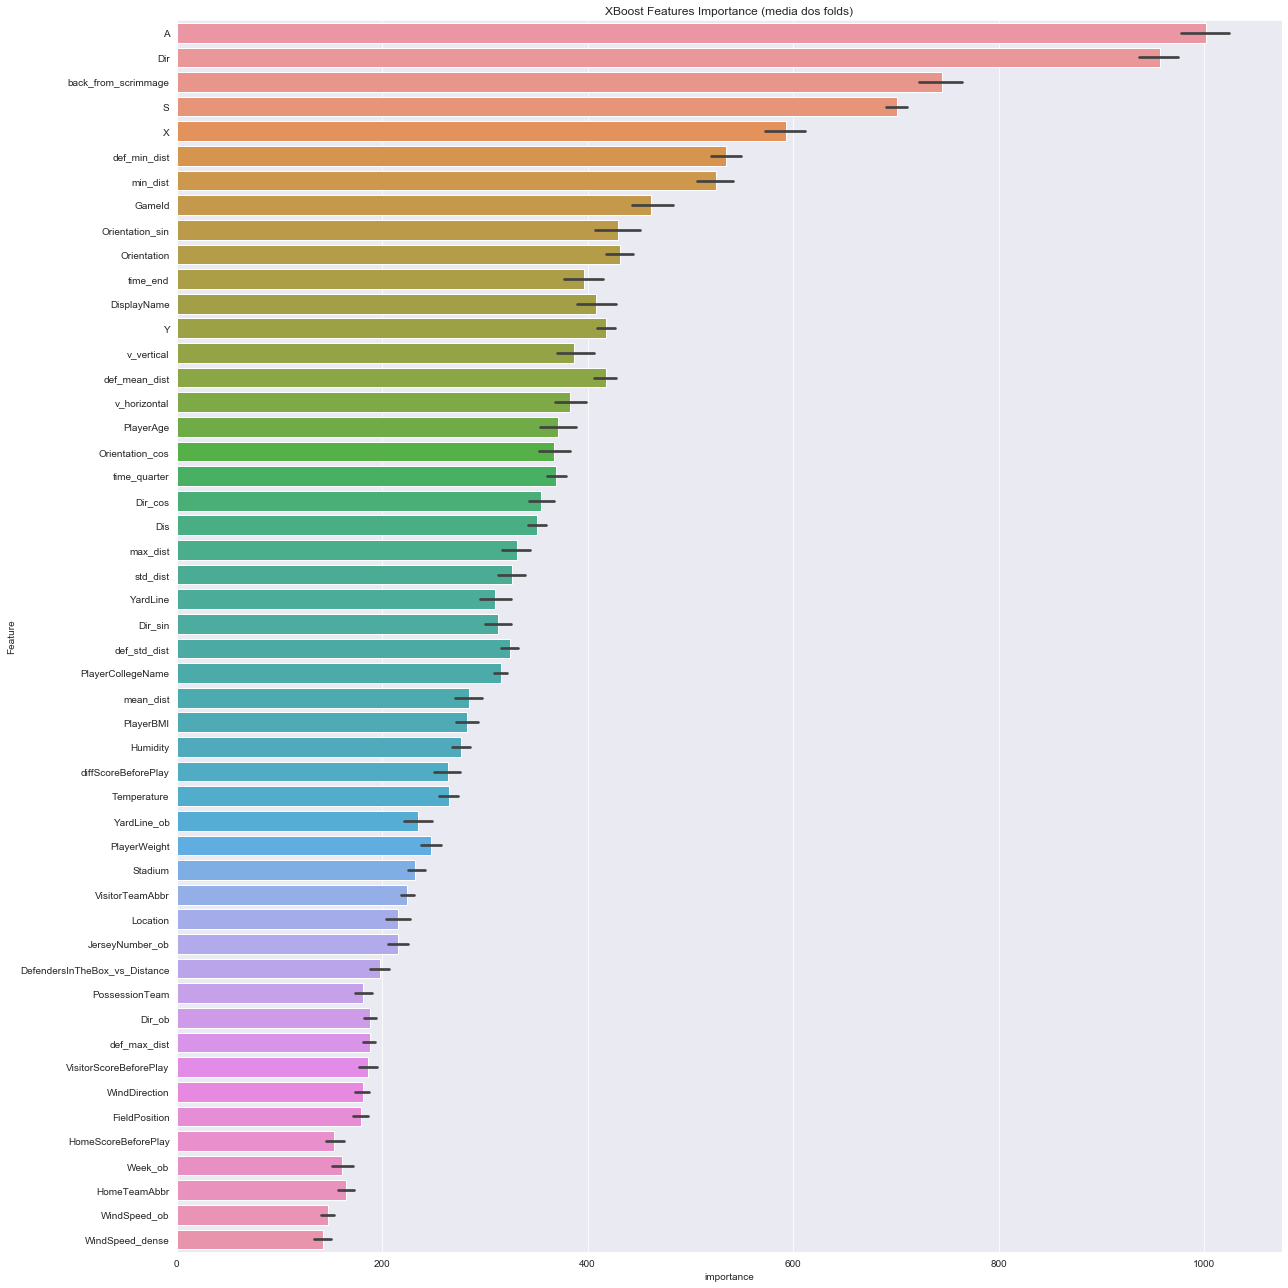

In [53]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XBoost Features Importance (media dos folds)')
plt.tight_layout()

In [69]:
import xgboost as XGB
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(X_train))
tr_rmse  = []
val_rmse = []
models   = []

folds = KFold(10, shuffle = True)
for fold_, (tr_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):

    tr_x, vl_x = X_train.iloc[tr_idx][features], X_train.iloc[val_idx][features]
    tr_y, vl_y = y_tr[tr_idx], y_tr[val_idx]

    print({'Fold: ':fold_, 'Train size':len(tr_x), 'Val size':len(vl_x)})

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    
    model = XGB.XGBRegressor(objective='reg:squarederror',
                             max_depth=8,
                             n_estimators=1000,
                             min_child_weight=300,
                             colsample_bytree=0.8,
                             subsample=0.8,
                             eta=0.001,
                             metric=funcao_crps,
                             seed=42)

    model.fit(tr_x, tr_y,
              #eval_metric=funcao_crps,
              eval_set=[(vl_x, vl_y)],
              verbose=200,
              early_stopping_rounds = 100)
    
    oof[val_idx] = model.predict(vl_x)
    
    val_score = mean_squared_error(vl_y, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(tr_y, model.predict(tr_x))
    tr_rmse.append(tr_score)
    
    models.append(model)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = tr_x.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(tr_x.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
gc.collect()

{'Fold: ': 0, 'Train size': 20853, 'Val size': 2318}
[0]	validation_0-rmse:1.09082
Will train until validation_0-rmse hasn't improved in 100 rounds.
[200]	validation_0-rmse:0.963619
Stopping. Best iteration:
[130]	validation_0-rmse:0.961366

{'Fold: ': 1, 'Train size': 20854, 'Val size': 2317}
[0]	validation_0-rmse:1.10716
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[63]	validation_0-rmse:0.971229

{'Fold: ': 2, 'Train size': 20854, 'Val size': 2317}
[0]	validation_0-rmse:1.16919
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[65]	validation_0-rmse:1.03764

{'Fold: ': 3, 'Train size': 20854, 'Val size': 2317}
[0]	validation_0-rmse:1.05571
Will train until validation_0-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[30]	validation_0-rmse:0.914856

{'Fold: ': 4, 'Train size': 20854, 'Val size': 2317}
[0]	validation_0-rmse:1.06729
Will train until validation_0-rmse hasn't improved i

12099

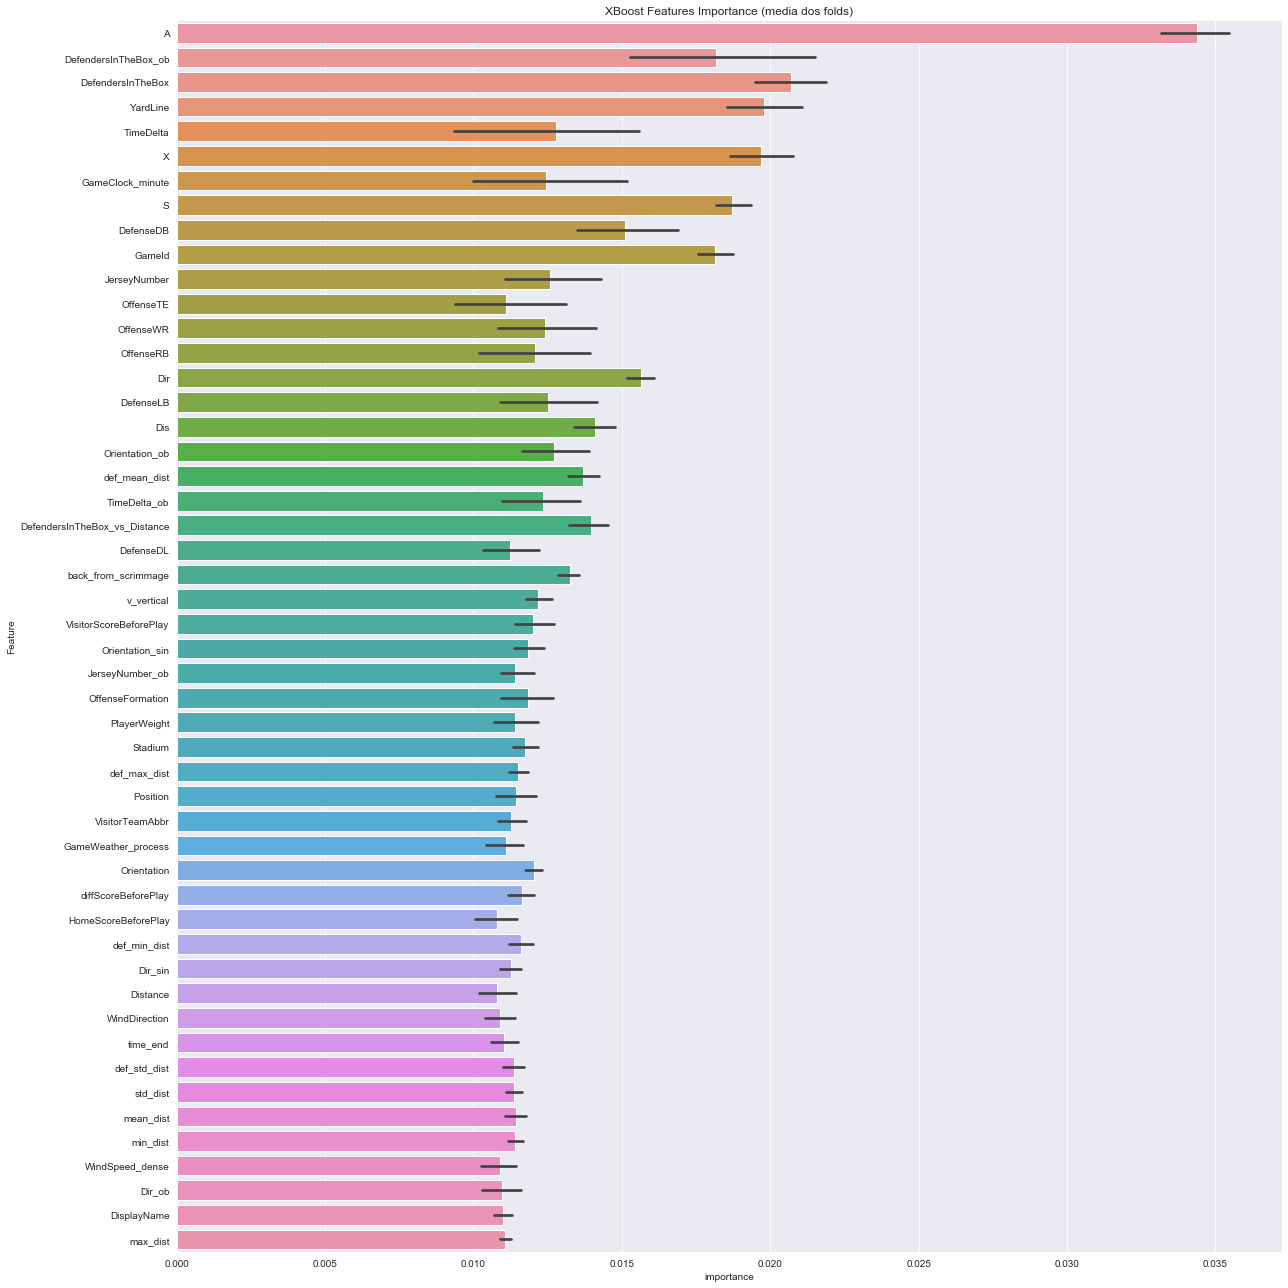

In [70]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XBoost Features Importance (media dos folds)')
plt.tight_layout()

In [57]:
from catboost import CatBoostRegressor
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(X_train))
tr_rmse  = []
val_rmse = []
models   = []

folds = KFold(10, shuffle = True)
for fold_, (tr_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):

    tr_x, vl_x = X_train.iloc[tr_idx][features], X_train.iloc[val_idx][features]
    tr_y, vl_y = y_tr[tr_idx], y_tr[val_idx]

    print({'Fold: ':fold_, 'Train size':len(tr_x), 'Val size':len(vl_x)})

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  
    
    model = CatBoostRegressor(n_estimators=1000,
                              learning_rate=0.001)

    model.fit(tr_x, tr_y,
              eval_set=[(vl_x, vl_y)],
              #early_stopping_rounds=100,
              use_best_model=True,
              verbose=20,
              metric=funcao_crps)
    
    oof[val_idx] = model.predict(vl_x)
    
    val_score = mean_squared_error(vl_y, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(tr_y, model.predict(tr_x))
    tr_rmse.append(tr_score)
    
    models.append(model)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = tr_x.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(tr_x.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
gc.collect()

{'Fold: ': 0, 'Train size': 20853, 'Val size': 2318}
0:	learn: 1.0056176	test: 0.9477564	best: 0.9477564 (0)	total: 176ms	remaining: 2m 56s
20:	learn: 1.0050290	test: 0.9477573	best: 0.9477330 (18)	total: 1.34s	remaining: 1m 2s
40:	learn: 1.0045336	test: 0.9477264	best: 0.9477101 (32)	total: 2.46s	remaining: 57.4s
60:	learn: 1.0039831	test: 0.9477721	best: 0.9477101 (32)	total: 3.56s	remaining: 54.7s
80:	learn: 1.0033723	test: 0.9477687	best: 0.9477101 (32)	total: 4.72s	remaining: 53.6s
100:	learn: 1.0028572	test: 0.9477597	best: 0.9477101 (32)	total: 5.89s	remaining: 52.5s
120:	learn: 1.0022969	test: 0.9477159	best: 0.9477076 (119)	total: 7.19s	remaining: 52.2s
140:	learn: 1.0016971	test: 0.9477954	best: 0.9477076 (119)	total: 8.3s	remaining: 50.6s
160:	learn: 1.0010767	test: 0.9477875	best: 0.9477076 (119)	total: 9.46s	remaining: 49.3s
180:	learn: 1.0006452	test: 0.9478566	best: 0.9477076 (119)	total: 10.6s	remaining: 48.2s
200:	learn: 1.0001206	test: 0.9478710	best: 0.9477076 (119)	

200:	learn: 1.0027293	test: 0.9210068	best: 0.9209203 (176)	total: 13.5s	remaining: 53.7s
220:	learn: 1.0021274	test: 0.9211000	best: 0.9209203 (176)	total: 14.8s	remaining: 52.1s
240:	learn: 1.0015598	test: 0.9210713	best: 0.9209203 (176)	total: 16.1s	remaining: 50.7s
260:	learn: 1.0010545	test: 0.9210421	best: 0.9209203 (176)	total: 17.3s	remaining: 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9209203336
bestIteration = 176

Shrink model to first 177 iterations.


11730

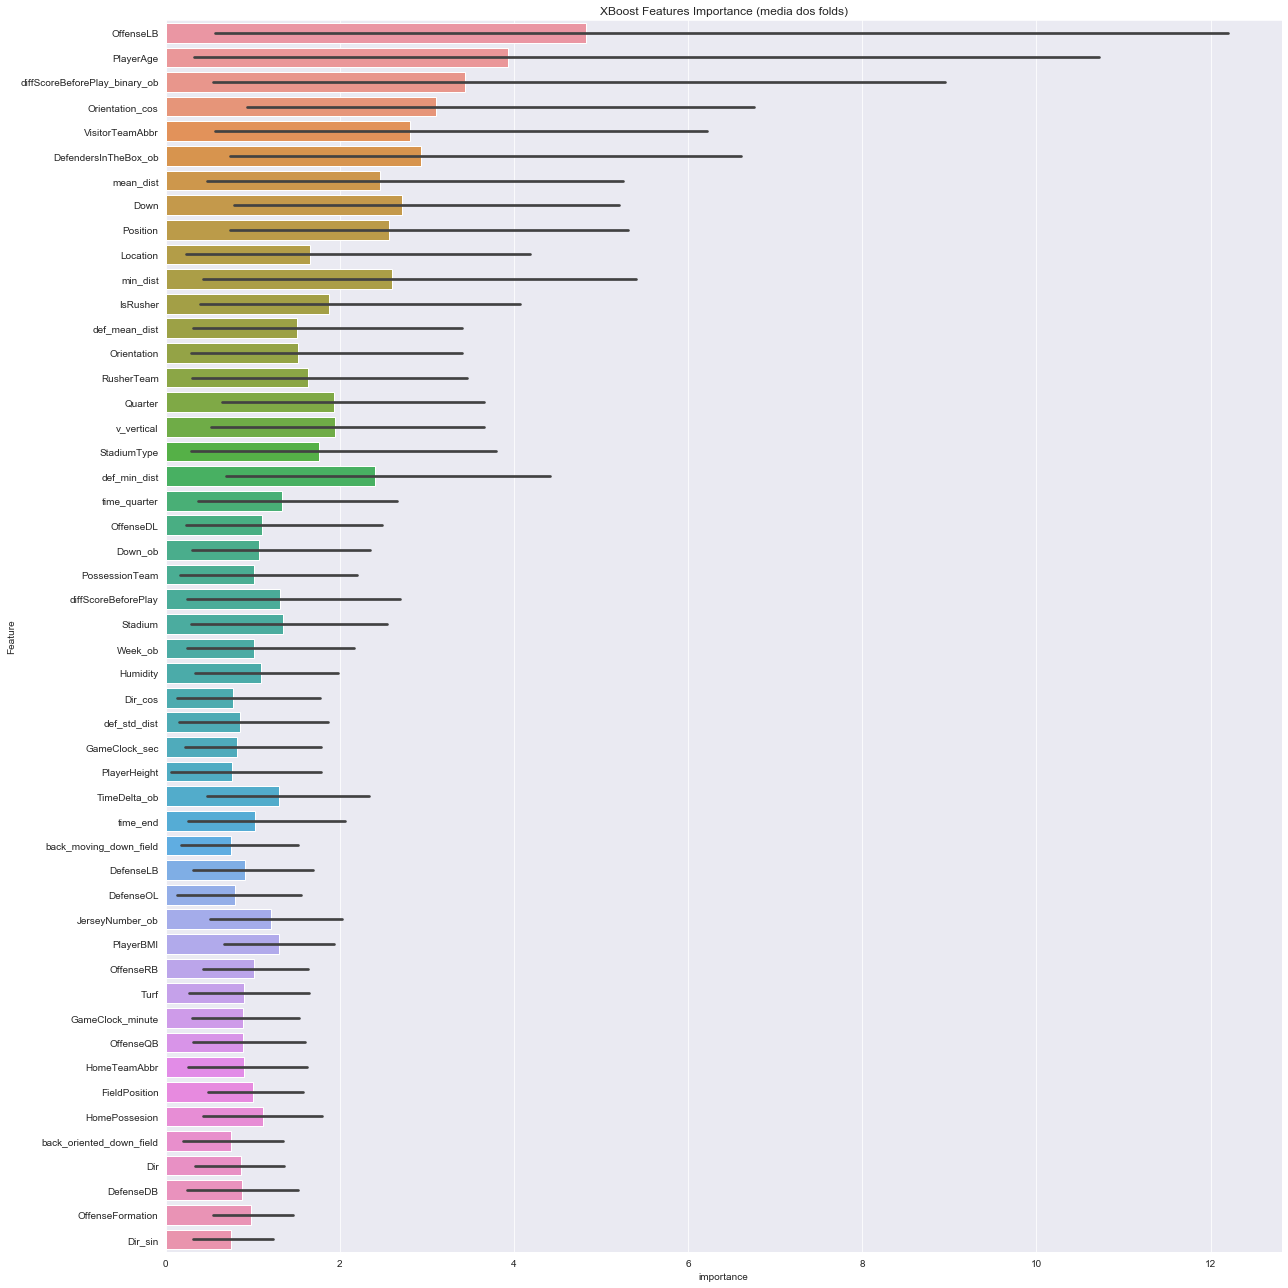

In [58]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XBoost Features Importance (media dos folds)')
plt.tight_layout()

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
feature_importance_df = pd.DataFrame()
oof = np.zeros(len(X_train))
tr_rmse  = []
val_rmse = []
models   = []

folds = KFold(10, shuffle = True)
for fold_, (tr_idx, val_idx) in enumerate(folds.split(X_train,y_tr)):

    tr_x, vl_x = X_train.iloc[tr_idx][features], X_train.iloc[val_idx][features]
    tr_y, vl_y = y_tr[tr_idx], y_tr[val_idx]

    print({'Fold: ':fold_, 'Train size':len(tr_x), 'Val size':len(vl_x)})

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)  

    model = GradientBoostingRegressor(n_estimators=100,
                                      learning_rate=0.001,
                                      max_depth=4,
                                      max_features='sqrt',
                                      min_samples_leaf=15,
                                      min_samples_split=10,
                                      loss='huber')  
    model.fit(tr_x, tr_y)
    
    oof[val_idx] = model.predict(vl_x)
    
    val_score = mean_squared_error(vl_y, oof[val_idx])
    val_rmse.append(val_score)
    
    tr_score = mean_squared_error(tr_y, model.predict(tr_x))
    tr_rmse.append(tr_score)
    
    models.append(model)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = tr_x.columns
    fold_importance_df["importance"] = model.feature_importances_[:len(tr_x.columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
gc.collect()

{'Fold: ': 0, 'Train size': 20853, 'Val size': 2318}
{'Fold: ': 1, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 2, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 3, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 4, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 5, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 6, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 7, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 8, 'Train size': 20854, 'Val size': 2317}
{'Fold: ': 9, 'Train size': 20854, 'Val size': 2317}


11653

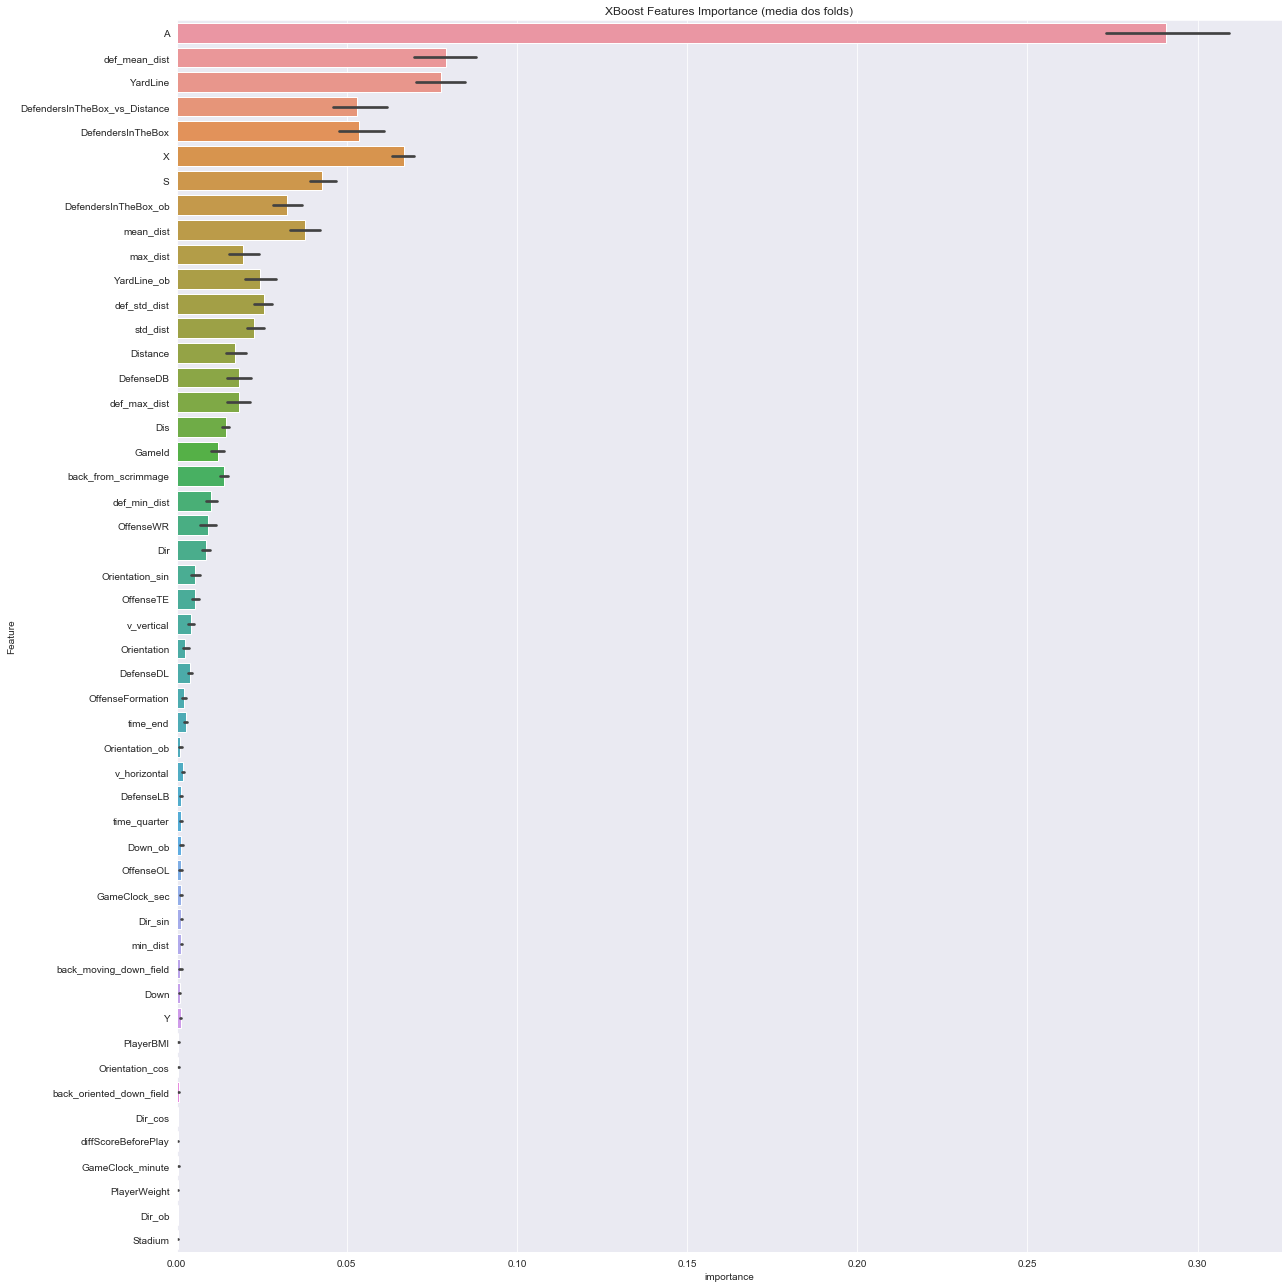

In [65]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(18,18))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XBoost Features Importance (media dos folds)')
plt.tight_layout()

In [ ]:
# Validacao do modelo
# Imprimir o score de treino e teste

mean_rmse_tr = np.mean(tr_rmse)
std_rmse_tr =  np.std(tr_rmse)

mean_rmse_val =  np.mean(val_rmse)
std_rmse_val =  np.std(val_rmse)

all_rmse = mean_squared_error(oof,y_tr)

print("Score de Treino")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_tr, std_rmse_tr),'\n')

print("Score de Validação")
print("Média RMSE: %.5f, std: %.5f." % (mean_rmse_val, std_rmse_val),'\n')

print("Geral: %.5f." % (all_rmse),'\n')

print("CRPS: %.5f." % (funcao_crps(y_tr,oof)[1]))

## Prediction

In [ ]:
def make_pred(test, sample, env, model):
    test_basetable1 = create_features(test, True)
    
    test_basetable2 = preprocess(test)
    test_basetable2 = drop(test_basetable2, True)
    
    test = pd.merge(test_basetable1, test_basetable2, on='PlayId', how='inner')

    ### categorical
    test_cat = test[cat_features]
    for col in (test_cat.columns):
        test_cat.loc[:,col] = test_cat[col].fillna("nan")
        test_cat.loc[:,col] = col + "__" + test_cat[col].astype(str)
        isnan = ~test_cat.loc[:,col].isin(categories)
        if np.sum(isnan) > 0:
            if not ((col + "__nan") in categories):
                test_cat.loc[isnan,col] = most_appear_each_categories[col]
            else:
                test_cat.loc[isnan,col] = col + "__nan"
    for col in (test_cat.columns):
        test_cat.loc[:, col] = le.transform(test_cat[col])

    ### dense
    test_dense = test[dense_features]
    for col in (test_dense.columns):
        test_dense.loc[:, col] = test_dense[col].fillna(medians[col])
        test_dense.loc[:, col] = sss[col].transform(test_dense[col].values[:,None])

    ### divide
    test_dense_players = [test_dense[dense_player_features].iloc[np.arange(k, len(test), 22)].reset_index(drop = True) for k in range(22)]
    test_dense_players = np.stack([t.values for t in test_dense_players]).transpose(1,0, 2)

    test_dense_game = test_dense[dense_game_features].iloc[np.arange(0, len(test), 22)].reset_index(drop = True).values
    test_dense_game = np.hstack([test_dense_game, test_dense[dense_player_features][test_dense["IsRusher"] > 0]])
    
    test_cat_players = [test_cat[cat_player_features].iloc[np.arange(k, len(test), 22)].reset_index(drop = True) for k in range(22)]
    test_cat_players = np.stack([t.values for t in test_cat_players]).transpose(1,0, 2)

    test_cat_game = test_cat[cat_game_features].iloc[np.arange(0, len(test), 22)].reset_index(drop = True).values
    test_cat_game = np.hstack([test_cat_game, test_cat[cat_player_features][test_dense["IsRusher"] > 0]])

    test_inp = [test_dense_game, test_dense_players, test_cat_game, test_cat_players]
    
    ## pred
    pred = 0
    for model in models:
        _pred = model.predict(test_inp)[0]
        _pred = np.cumsum(_pred, axis = 1)
        pred += _pred
    pred /= len(models)
    pred = np.clip(pred, 0, 1)
    env.predict(pd.DataFrame(data=pred,columns=sample.columns))
    return pred

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()
preds = []
for test, sample in tqdm_notebook(env.iter_test()):
    pred = make_pred(test, sample, env, models)
    preds.append(pred)
env.write_submission_file()

In [ ]:
preds = np.vstack(preds)
## check whether prediction is submittable
print(np.mean(np.diff(preds, axis = 1) >= 0) == 1.0)
print(np.mean(preds > 1) == 0)

In [ ]:
print(losses)
print(np.mean(losses))